All modules reloaded successfully
CLUSTER ALGORITHM VALIDATION


Running test case 1/51...
  -> Case 1
  Decision mode: CMI-based statistical testing (α=0.0001)

Running test case 2/51...
  -> Case 2
  Decision mode: CMI-based statistical testing (α=0.0001)

Running test case 3/51...
  -> Case 3
  Decision mode: CMI-based statistical testing (α=0.0001)

Running test case 4/51...
  -> Case 4
  Decision mode: CMI-based statistical testing (α=0.0001)

Running test case 5/51...
  -> Case 5
  Decision mode: CMI-based statistical testing (α=0.0001)

Running test case 6/51...
  -> Case 6
  Decision mode: CMI-based statistical testing (α=0.0001)

Running test case 7/51...
  -> Case 7
  Decision mode: CMI-based statistical testing (α=0.0001)

Running test case 8/51...
  -> Case 8
  Decision mode: CMI-based statistical testing (α=0.0001)

Running test case 9/51...
  -> Case 9
  Decision mode: CMI-based statistical testing (α=0.0001)

Running test case 10/51...
  -> Case 10
  Decision mode: CMI-b

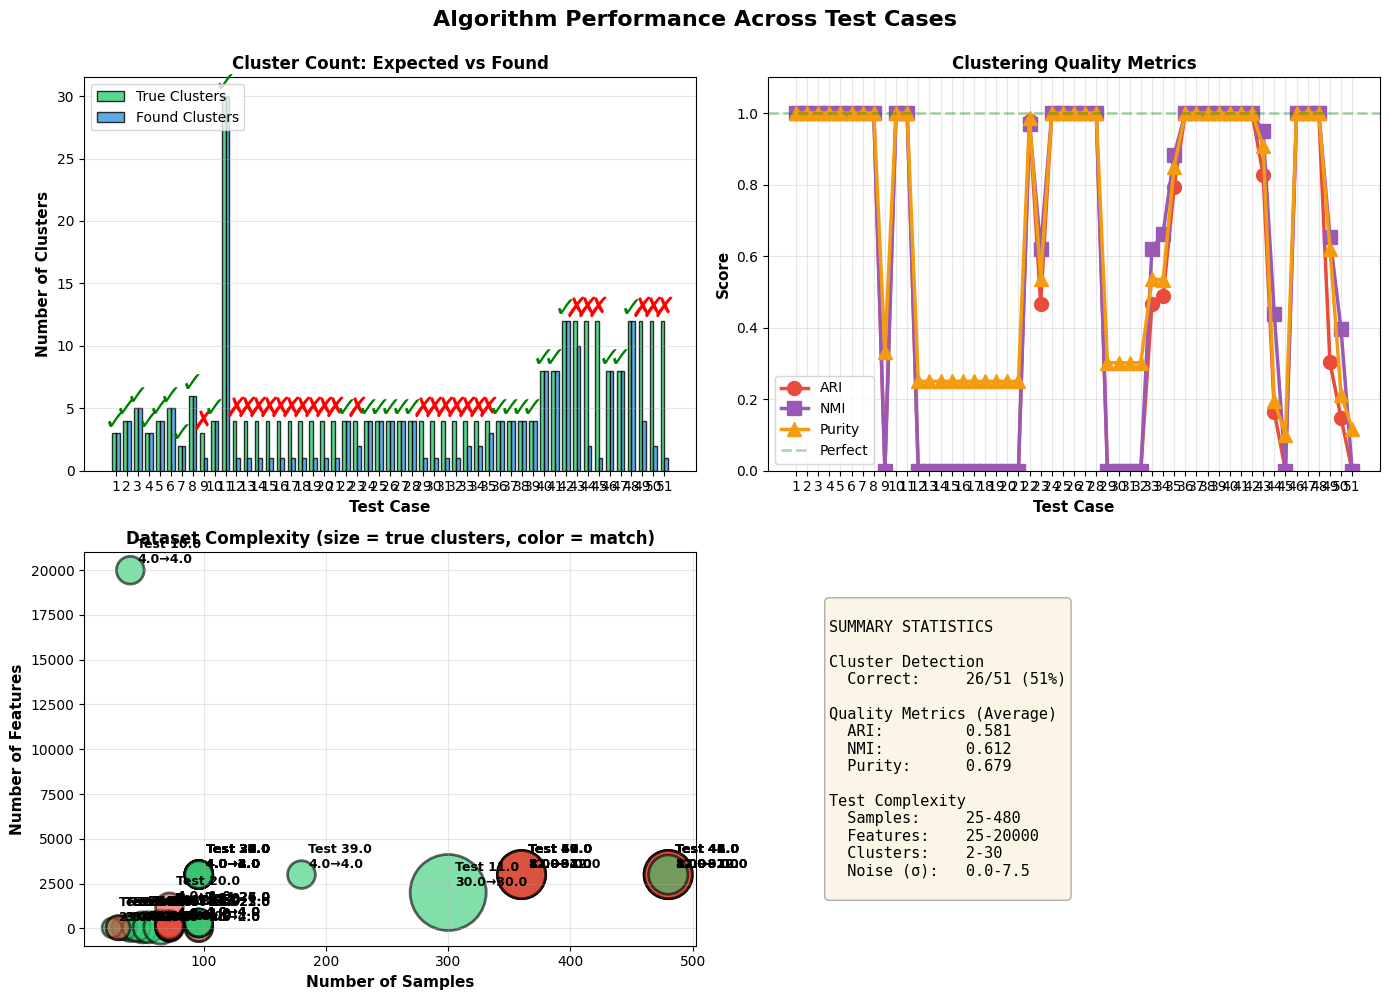

In [ ]:
# Setup Python path to import from project root
import sys
import os
sys.path.append(os.path.abspath('..'))

# Force reload of all modules to pick up changes
import importlib
modules_to_reload = [
    'kl_clustering_analysis.tests.test_cluster_validation',
    'kl_clustering_analysis.hierarchy_analysis.statistics',
    'kl_clustering_analysis.hierarchy_analysis.cluster_decomposition',
    'kl_clustering_analysis.misc.plot_cluster_trees',
    'kl_clustering_analysis.tree.poset_tree',
    'kl_clustering_analysis.hierarchy_analysis.kl_correlation_analysis',
    'kl_clustering_analysis.hierarchy_analysis.decomposition_utils',
]

for module_name in modules_to_reload:
    if module_name in sys.modules:
        importlib.reload(sys.modules[module_name])
    else:
        __import__(module_name)

print("All modules reloaded successfully")

# 6. Validation: Multiple Test Cases
from kl_clustering_analysis.tests.test_cluster_validation import validate_cluster_algorithm
import pandas as pd
from datetime import datetime

# Run validation with default test cases and UMAP plotting enabled
df_results, fig = validate_cluster_algorithm(
    significance_level=0.0001,
    verbose=True,
    plot_umap=True
)

# Save validation results to results folder
current_date = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
results_file = f"../results/validation_results_{current_date}.csv"
df_results.to_csv(results_file, index=False)
print(f"Validation results saved to {results_file}")
print(f"Results summary:\n{df_results}")

Testing clustering on spiral dataset...
Building hierarchical tree...
Tree built with 299 nodes
Running statistical analysis...
Statistical analysis complete. MI matrix shape: (149, 149)
Spiral dataset: 150 samples, 2 features
True clusters: 3 spirals
Found clusters: 4


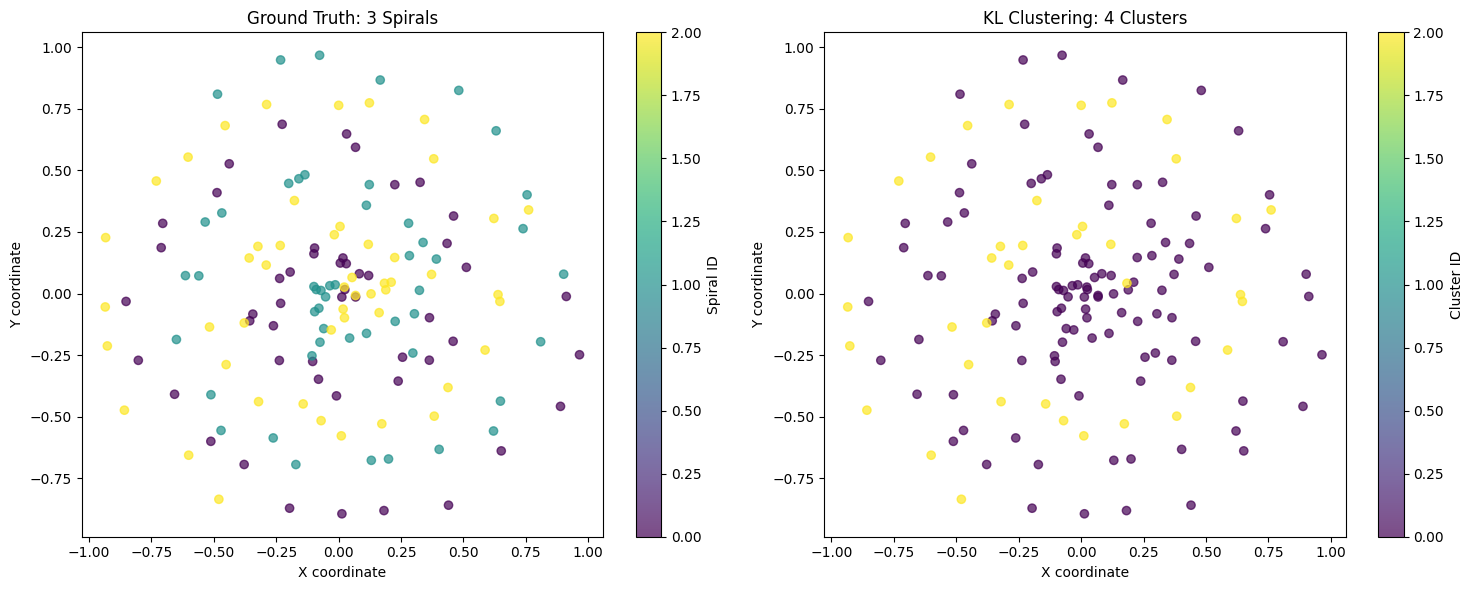

Spiral clustering results saved to ../results/spiral_clustering_results_2025-10-31_19-10-45.csv
Spiral clustering test completed - results saved to '../cluster_tree_plots/spiral_clustering_test.png'


In [ ]:
# 7. Test on Spiral Dataset (Challenging Non-Convex Clustering)
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys
import os
sys.path.append(os.path.abspath('..'))

from kl_clustering_analysis.misc.plot_cluster_trees import (
    build_hierarchical_tree,
    run_statistical_analysis,
)
from kl_clustering_analysis.hierarchy_analysis.cluster_decomposition import ClusterDecomposer

def create_spiral_dataset(n_samples=200, n_spirals=3, noise=0.1, seed=42):
    """Create a spiral dataset that's challenging for traditional clustering."""
    np.random.seed(seed)

    # Create spiral arms
    t = np.linspace(0, 4*np.pi, n_samples//n_spirals)
    spirals = []

    for i in range(n_spirals):
        # Create spiral coordinates
        r = t / (4*np.pi)  # radius increases with angle
        x = r * np.cos(t + i * 2*np.pi/n_spirals)
        y = r * np.sin(t + i * 2*np.pi/n_spirals)

        # Add noise
        x += np.random.normal(0, noise, len(x))
        y += np.random.normal(0, noise, len(y))

        spirals.append(np.column_stack([x, y]))

    # Combine all spirals
    X = np.vstack(spirals)

    # Create binary features (binarize)
    X_binary = (X > np.median(X, axis=0)).astype(int)
    data = pd.DataFrame(
        X_binary,
        index=[f"S{j}" for j in range(len(X))],
        columns=[f"F{j}" for j in range(X.shape[1])],
    )

    # True labels (which spiral each point belongs to)
    y_true = np.repeat(range(n_spirals), n_samples//n_spirals)

    return data, y_true, X

print("Testing clustering on spiral dataset...")
spiral_data, spiral_labels, spiral_coords = create_spiral_dataset(n_samples=150, n_spirals=3, noise=0.05)

# Build tree and run clustering
tree_spiral, _ = build_hierarchical_tree(spiral_data)
mi_matrix_spiral, results_df_spiral = run_statistical_analysis(tree_spiral, spiral_data)

decomposer_spiral = ClusterDecomposer(
    tree=tree_spiral,
    results_df=results_df_spiral,
    significance_column="Are_Features_Dependent",
)
result_spiral = decomposer_spiral.decompose_tree()

# Create report dataframe from cluster assignments
cluster_assignments = result_spiral.get("cluster_assignments", {})
if cluster_assignments:
    rows = []
    for cid, info in cluster_assignments.items():
        for leaf in info["leaves"]:
            rows.append({
                "sample_id": leaf,
                "cluster_id": cid,
                "cluster_root": info["root_node"],
                "cluster_size": info["size"],
            })
    report_spiral = pd.DataFrame(rows).set_index("sample_id")
else:
    report_spiral = pd.DataFrame(columns=["cluster_id", "cluster_root", "cluster_size"]).set_index("sample_id")

print(f"Spiral dataset: {len(spiral_data)} samples, {spiral_data.shape[1]} features")
print(f"True clusters: 3 spirals")
print(f"Found clusters: {result_spiral['num_clusters']}")

# Visualize the spiral clustering result
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot ground truth
scatter1 = ax1.scatter(spiral_coords[:, 0], spiral_coords[:, 1], c=spiral_labels, cmap='viridis', alpha=0.7)
ax1.set_title('Ground Truth: 3 Spirals')
ax1.set_xlabel('X coordinate')
ax1.set_ylabel('Y coordinate')
plt.colorbar(scatter1, ax=ax1, label='Spiral ID')

# Plot clustering result
if not report_spiral.empty:
    # Map cluster IDs to match the spiral structure for better visualization
    cluster_mapping = {}
    for i, row in report_spiral.iterrows():
        true_spiral = spiral_labels[int(row.name[1:])]  # Extract sample index
        cluster_id = row['cluster_id']
        if cluster_id not in cluster_mapping:
            cluster_mapping[cluster_id] = true_spiral

    # Apply mapping
    mapped_clusters = [cluster_mapping.get(row['cluster_id'], 0) for _, row in report_spiral.iterrows()]
    scatter2 = ax2.scatter(spiral_coords[:, 0], spiral_coords[:, 1], c=mapped_clusters, cmap='viridis', alpha=0.7)
else:
    # No clusters found
    scatter2 = ax2.scatter(spiral_coords[:, 0], spiral_coords[:, 1], c='gray', alpha=0.7)

ax2.set_title(f'KL Clustering: {result_spiral["num_clusters"]} Clusters')
ax2.set_xlabel('X coordinate')
ax2.set_ylabel('Y coordinate')
plt.colorbar(scatter2, ax=ax2, label='Cluster ID')

plt.tight_layout()
plt.savefig('../cluster_tree_plots/spiral_clustering_test.png', dpi=150, bbox_inches='tight')
plt.show()

# Save clustering results to results folder
from datetime import datetime
current_date = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
results_file = f"../results/spiral_clustering_results_{current_date}.csv"
report_spiral.to_csv(results_file)
print(f"Spiral clustering results saved to {results_file}")

print("Spiral clustering test completed - results saved to '../cluster_tree_plots/spiral_clustering_test.png'")

In [ ]:
# 8. Test on 3D Swiss Roll Dataset (Manifold Learning Challenge)

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys
import os
sys.path.append(os.path.abspath('..'))

from kl_clustering_analysis.misc.plot_cluster_trees import (
    build_hierarchical_tree,
    run_statistical_analysis,
)
from kl_clustering_analysis.hierarchy_analysis.cluster_decomposition import ClusterDecomposer
from sklearn.datasets import make_swiss_roll

def create_swiss_roll_dataset(n_samples=300, noise=0.05, seed=42):
    """Create a 3D Swiss roll dataset for manifold clustering testing."""
    np.random.seed(seed)
    
    # Generate Swiss roll data
    X, t = make_swiss_roll(n_samples=n_samples, noise=noise, random_state=seed)
    
    # Create binary features by quantizing the coordinates
    X_binary = np.zeros((n_samples, 6), dtype=int)
    
    # Bin the coordinates into binary features
    for i in range(3):  # x, y, z coordinates
        median_val = np.median(X[:, i])
        X_binary[:, i*2] = (X[:, i] > median_val).astype(int)
        # Also create features based on quadrants
        X_binary[:, i*2 + 1] = ((X[:, i] - median_val) > 0).astype(int)
    
    # Create DataFrame
    data = pd.DataFrame(
        X_binary,
        index=[f"S{j}" for j in range(n_samples)],
        columns=[f"F{j}" for j in range(X_binary.shape[1])],
    )
    
    # True labels based on the manifold parameter t (color along the roll)
    y_true = (t / t.max() * 3).astype(int)  # 3 color bands along the roll
    
    return data, y_true, X

print("Testing clustering on 3D Swiss roll dataset...")
swiss_data, swiss_labels, swiss_coords = create_swiss_roll_dataset(n_samples=300, noise=0.1)

# Build tree and run clustering
tree_swiss, _ = build_hierarchical_tree(swiss_data)
mi_matrix_swiss, results_df_swiss = run_statistical_analysis(tree_swiss, swiss_data)

decomposer_swiss = ClusterDecomposer(
    tree=tree_swiss,
    results_df=results_df_swiss,
    significance_column="Are_Features_Dependent",
)
result_swiss = decomposer_swiss.decompose_tree()

# Create report dataframe from cluster assignments
cluster_assignments = result_swiss.get("cluster_assignments", {})
if cluster_assignments:
    rows = []
    for cid, info in cluster_assignments.items():
        for leaf in info["leaves"]:
            rows.append({
                "sample_id": leaf,
                "cluster_id": cid,
                "cluster_root": info["root_node"],
                "cluster_size": info["size"],
            })
    report_swiss = pd.DataFrame(rows).set_index("sample_id")
else:
    report_swiss = pd.DataFrame(columns=["cluster_id", "cluster_root", "cluster_size"]).set_index("sample_id")

print(f"Swiss roll dataset: {len(swiss_data)} samples, {swiss_data.shape[1]} features")
print(f"True clusters: 3 (based on manifold coloring)")
print(f"Found clusters: {result_swiss['num_clusters']}")

# Visualize the Swiss roll clustering result
fig = plt.figure(figsize=(15, 6))

# 3D plot of ground truth
ax1 = fig.add_subplot(121, projection='3d')
scatter1 = ax1.scatter(swiss_coords[:, 0], swiss_coords[:, 1], swiss_coords[:, 2], 
                      c=swiss_labels, cmap='viridis', alpha=0.7)
ax1.set_title('Ground Truth: Swiss Roll Coloring')
ax1.set_xlabel('X')
ax1.set_ylabel('Y') 
ax1.set_zlabel('Z')
plt.colorbar(scatter1, ax=ax1, shrink=0.5, label='Color band')

# 3D plot of clustering result
ax2 = fig.add_subplot(122, projection='3d')

# Map cluster IDs for visualization
if not report_swiss.empty:
    cluster_mapping = {}
    # Create a simple mapping based on cluster size for visualization
    cluster_sizes = report_swiss.groupby('cluster_id').size().sort_values(ascending=False)
    for i, cluster_id in enumerate(cluster_sizes.index):
        cluster_mapping[cluster_id] = i % len(plt.cm.tab10.colors)
    
    mapped_clusters = [cluster_mapping.get(row['cluster_id'], 0) for _, row in report_swiss.iterrows()]
    
    scatter2 = ax2.scatter(swiss_coords[:, 0], swiss_coords[:, 1], swiss_coords[:, 2], 
                          c=mapped_clusters, cmap='tab10', alpha=0.7)
    ax2.set_title(f'KL Clustering: {result_swiss["num_clusters"]} Clusters')
else:
    # No clusters found, show all points in same color
    scatter2 = ax2.scatter(swiss_coords[:, 0], swiss_coords[:, 1], swiss_coords[:, 2], 
                          c='gray', alpha=0.7)
    ax2.set_title('KL Clustering: No Clusters Found')

ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_zlabel('Z')
if not report_swiss.empty:
    plt.colorbar(scatter2, ax=ax2, shrink=0.5, label='Cluster ID')

plt.tight_layout()
plt.savefig('../cluster_tree_plots/3d_swiss_roll_clustering_test.png', dpi=150, bbox_inches='tight')
plt.show()

# Save clustering results to results folder
from datetime import datetime
current_date = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
results_file = f"../results/swiss_roll_clustering_results_{current_date}.csv"
report_swiss.to_csv(results_file)
print(f"Swiss roll clustering results saved to {results_file}")

print("3D Swiss Roll clustering test completed - results saved to '../cluster_tree_plots/3d_swiss_roll_clustering_test.png'")

Testing clustering on 3D Swiss roll dataset...


NameError: name 'np' is not defined